In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/parsing-all-moscow-auto-ru-09-09-2020/all_auto_ru_09_09_2020.csv
/kaggle/input/auto-ru-car-ads-parsed/data1.csv
/kaggle/input/sf-dst-car-price-prediction/sample_submission.csv
/kaggle/input/sf-dst-car-price-prediction/test.csv


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.linear_model import RidgeCV, ElasticNet, Lasso
from sklearn.ensemble import (RandomForestRegressor, BaggingRegressor,
                              GradientBoostingRegressor,AdaBoostRegressor, StackingRegressor)
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.preprocessing import PolynomialFeatures

In [3]:
RANDOM_SEED = 42

VERSION = 11
VAL_SIZE = 0.2   # 20% данных для локального тестирования и валидации
N_FOLDS = 5

In [4]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Data

In [5]:
train = pd.read_csv('../input/parsing-all-moscow-auto-ru-09-09-2020/all_auto_ru_09_09_2020.csv')

In [6]:
train2 = pd.read_csv('../input/auto-ru-car-ads-parsed/data1.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
test = pd.read_csv('../input/sf-dst-car-price-prediction/test.csv')
sample_submission = pd.read_csv('../input/sf-dst-car-price-prediction/sample_submission.csv')
sample_submission_final = pd.read_csv('../input/sf-dst-car-price-prediction/sample_submission.csv')

In [8]:
test.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [10]:
train.head()

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,65000.0,2020-08-23T17:40:09Z,NaN,100
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,...,LEFT,NaN,3.0,DUPLICATE,True,NaN,100000.0,2020-09-08T09:22:07Z,NaN,100


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [12]:
train2.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,is_train,price
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2,105.0,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,False,0
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6,110.0,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,False,0
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8,152.0,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,False,0
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6,110.0,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,False,0
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8,152.0,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,False,0


In [13]:
train2 = train2[train2.is_train == True]
train2.drop(columns=['is_train'], inplace=True)

In [14]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36210 entries, 34686 to 70895
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              36210 non-null  object 
 1   brand                 36210 non-null  object 
 2   car_url               36210 non-null  object 
 3   color                 36210 non-null  object 
 4   complectation_dict    36210 non-null  object 
 5   description           35210 non-null  object 
 6   engineDisplacement    36210 non-null  float64
 7   enginePower           36210 non-null  float64
 8   equipment_dict        36210 non-null  object 
 9   fuelType              36210 non-null  object 
 10  image                 36210 non-null  object 
 11  mileage               36210 non-null  int64  
 12  modelDate             36210 non-null  float64
 13  model_info            36210 non-null  object 
 14  model_name            36210 non-null  object 
 15  name           

In [15]:
train.drop(train[train['bodyType'].isna()].index, inplace=True)

train.rename(columns={'model':'model_name'}, inplace=True)

In [16]:
cols_delete_test = set(test.columns) - set(train.columns)
cols_delete_test

{'car_url',
 'complectation_dict',
 'equipment_dict',
 'image',
 'model_info',
 'parsing_unixtime',
 'priceCurrency',
 'sell_id',
 'super_gen',
 'vendor'}

In [17]:
cols_delete_train = set(train.columns) - set(test.columns)
cols_delete_train.remove('price')
cols_delete_train

{'hidden', 'start_date', 'Комплектация'}

In [18]:
cols_delete_train2 = set(train2.columns) - set(train.columns)
cols_delete_train2

{'car_url',
 'complectation_dict',
 'equipment_dict',
 'image',
 'model_info',
 'parsing_unixtime',
 'priceCurrency',
 'sell_id',
 'super_gen',
 'vendor'}

In [19]:
train.drop(columns=cols_delete_train, inplace=True)
train2.drop(columns=cols_delete_train2, inplace=True)
test.drop(columns=cols_delete_test, inplace=True)
print(train.shape[1], train2.shape[1], test.shape[1])

23 23 22


In [20]:
order = test.columns.to_list()
train = train[order + ['price']]
train2 = train2[order + ['price']]

train = pd.concat([train, train2], ignore_index=True)

# Data preperation and Feature engineering

In [21]:
to_delete = []

In [22]:
test.isna().sum()

bodyType                    0
brand                       0
color                       0
description                 0
engineDisplacement          0
enginePower                 0
fuelType                    0
mileage                     0
modelDate                   0
model_name                  0
name                        0
numberOfDoors               0
productionDate              0
vehicleConfiguration        0
vehicleTransmission         0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

In [23]:
train.isna().sum()

bodyType                    0
brand                       0
color                       0
description              4254
engineDisplacement          0
enginePower                 0
fuelType                    0
mileage                     0
modelDate                   0
model_name                  0
name                        0
numberOfDoors               0
productionDate              0
vehicleConfiguration        0
vehicleTransmission         0
Владельцы               13588
Владение                87062
ПТС                       361
Привод                      0
Руль                        0
Состояние               89377
Таможня                     0
price                     410
dtype: int64

In [24]:
to_delete.append('Владение')

In [25]:
for col in test.columns:
    print(col, ':', test[col].nunique())

bodyType : 24
brand : 12
color : 16
description : 31732
engineDisplacement : 55
enginePower : 315
fuelType : 5
mileage : 11268
modelDate : 66
model_name : 544
name : 2780
numberOfDoors : 5
productionDate : 69
vehicleConfiguration : 634
vehicleTransmission : 4
Владельцы : 3
Владение : 275
ПТС : 2
Привод : 3
Руль : 2
Состояние : 1
Таможня : 1


In [26]:
to_delete += ['Состояние', 'Таможня']

### bodyType

In [27]:
train.bodyType = train.bodyType.astype(str)
train.bodyType = train.bodyType.apply(lambda x: x.capitalize())
test.bodyType = test.bodyType.apply(lambda x: x.capitalize())

In [28]:
test.bodyType.unique()

array(['Лифтбек', 'Внедорожник 5 дв.', 'Хэтчбек 5 дв.', 'Седан',
       'Компактвэн', 'Универсал 5 дв.', 'Пикап одинарная кабина',
       'Хэтчбек 3 дв.', 'Купе', 'Кабриолет', 'Минивэн',
       'Пикап двойная кабина', 'Внедорожник 3 дв.', 'Родстер', 'Микровэн',
       'Седан 2 дв.', 'Купе-хардтоп', 'Фастбек', 'Тарга',
       'Внедорожник открытый', 'Лимузин', 'Пикап полуторная кабина',
       'Седан-хардтоп', 'Фургон'], dtype=object)

In [29]:
train.bodyType.unique()

array(['Седан', 'Универсал 5 дв.', 'Хэтчбек 5 дв. sportback',
       'Хэтчбек 3 дв.', 'Хэтчбек 5 дв.', 'Кабриолет', 'Купе',
       'Лифтбек sportback', 'Лифтбек', 'Седан long', 'Внедорожник 5 дв.',
       'Кабриолет roadster', 'Седан 2 дв.', 'Седан gran coupe',
       'Компактвэн', 'Компактвэн gran tourer', 'Лифтбек gran turismo',
       'Хэтчбек 3 дв. compact', 'Лифтбек gran coupe', 'Купе-хардтоп',
       'Родстер roadster', 'Родстер', 'Внедорожник 5 дв. esv', 'Минивэн',
       'Пикап двойная кабина', 'Внедорожник 3 дв.',
       'Пикап одинарная кабина', 'Тарга', 'Пикап двойная кабина crew cab',
       'Пикап двойная кабина double',
       'Пикап одинарная кабина regular cab', 'Внедорожник 5 дв. ext',
       'Седан srt8', 'Минивэн swb', 'Минивэн grand', 'Компактвэн grand',
       'Универсал 5 дв. crosstourer', 'Минивэн long', 'Минивэн xl',
       'Микровэн coach', 'Хэтчбек 5 дв. best', 'Хэтчбек 5 дв. srt4',
       'Купе srt', 'Седан srt', 'Пикап полуторная кабина',
       'Пикап двойн

In [30]:
types = ['Купе-хардтоп', 'Седан-хардтоп', 'Седан 2 дв.'] + test['bodyType'].unique().tolist()

def bodyType_prep(b_type):
    for t in types:
        if t == b_type[:len(t)]:
            return b_type[:len(t)]
    return b_type

In [31]:
train.bodyType = train.bodyType.apply(bodyType_prep)
train.bodyType.unique()

array(['Седан', 'Универсал 5 дв.', 'Хэтчбек 5 дв.', 'Хэтчбек 3 дв.',
       'Кабриолет', 'Купе', 'Лифтбек', 'Внедорожник 5 дв.', 'Седан 2 дв.',
       'Компактвэн', 'Купе-хардтоп', 'Родстер', 'Минивэн',
       'Пикап двойная кабина', 'Внедорожник 3 дв.',
       'Пикап одинарная кабина', 'Тарга', 'Микровэн',
       'Пикап полуторная кабина', 'Фастбек', 'Хэтчбек 4 дв.',
       'Внедорожник открытый', 'Седан-хардтоп', 'Фургон', 'Лимузин',
       'Универсал 3 дв.1'], dtype=object)

In [32]:
set(test.bodyType) - set(train.bodyType)

# все типы данного признака в тестовой выворке присутствуют в трейн датасете

set()

In [33]:
# средняя стоимость каждого типа 
body_price = train.groupby(['bodyType'])['price'].mean().to_dict()
body_price

{'Внедорожник 3 дв.': 750237.5020491803,
 'Внедорожник 5 дв.': 2116855.4253853997,
 'Внедорожник открытый': 2704444.4444444445,
 'Кабриолет': 1893805.3951612904,
 'Компактвэн': 488639.42766295705,
 'Купе': 2461246.2542703757,
 'Купе-хардтоп': 1255713.2952755906,
 'Лимузин': 4332222.222222222,
 'Лифтбек': 922540.2691677589,
 'Микровэн': 365461.5128205128,
 'Минивэн': 1747452.2289042822,
 'Пикап двойная кабина': 1588551.4138728324,
 'Пикап одинарная кабина': 1567285.7142857143,
 'Пикап полуторная кабина': 1643269.1923076923,
 'Родстер': 3082352.668316832,
 'Седан': 1116969.744680851,
 'Седан 2 дв.': 1407714.2857142857,
 'Седан-хардтоп': 132500.0,
 'Тарга': 4096771.727272727,
 'Универсал 3 дв.1': 200000.0,
 'Универсал 5 дв.': 625763.3339059481,
 'Фастбек': 1836500.0,
 'Фургон': 567856.8784530386,
 'Хэтчбек 3 дв.': 441744.4029990628,
 'Хэтчбек 4 дв.': 797714.2857142857,
 'Хэтчбек 5 дв.': 503438.1341497356}

In [34]:
train['bodyType_mean'] = train['bodyType'].apply(lambda x: body_price[x])
test['bodyType_mean'] = test['bodyType'].apply(lambda x: body_price[x])

### brand

In [35]:
test.brand.unique()

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
      dtype=object)

In [36]:
train.brand.unique()

array(['AUDI', 'BMW', 'CADILLAC', 'CHERY', 'CHEVROLET', 'CHRYSLER',
       'CITROEN', 'DAEWOO', 'DODGE', 'FORD', 'GEELY', 'HONDA', 'HYUNDAI',
       'INFINITI', 'JAGUAR', 'JEEP', 'KIA', 'LEXUS', 'MAZDA', 'MINI',
       'MITSUBISHI', 'NISSAN', 'OPEL', 'PEUGEOT', 'PORSCHE', 'RENAULT',
       'SKODA', 'SUBARU', 'SUZUKI', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO',
       'GREAT_WALL', 'LAND_ROVER', 'MERCEDES', 'SSANG_YONG'], dtype=object)

In [37]:
set(test.brand) - set(train.brand)

# Все бренды в тестовой выборке представлены и в трейне

set()

In [38]:
# бренды которые нет в тествой выборке считаются за одну общую категорию
brands = test.brand.unique().tolist()
train['brand'] = train['brand'].apply(lambda x: x if x in brands else 'other')

In [39]:
train.brand.unique()

array(['AUDI', 'BMW', 'other', 'HONDA', 'INFINITI', 'LEXUS', 'MITSUBISHI',
       'NISSAN', 'SKODA', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO', 'MERCEDES'],
      dtype=object)

In [40]:
# средняя стоимость машин для каждого бренда
brand_price = train.groupby(['brand'])['price'].mean().to_dict()
brand_price

{'AUDI': 1596766.313139365,
 'BMW': 2459770.363136548,
 'HONDA': 623697.5703470032,
 'INFINITI': 1552688.636968085,
 'LEXUS': 2138656.5798383993,
 'MERCEDES': 4013430.088503883,
 'MITSUBISHI': 982999.6480569239,
 'NISSAN': 923526.7316188241,
 'SKODA': 771849.380247708,
 'TOYOTA': 1375494.9660731473,
 'VOLKSWAGEN': 1030480.8129595588,
 'VOLVO': 1828911.5712227253,
 'other': 772832.1786189078}

In [41]:
train['brand_mean'] = train['brand'].apply(lambda x: brand_price[x])
test['brand_mean'] = test['brand'].apply(lambda x: brand_price[x])

### color

In [42]:
test.color.unique()

array(['синий', 'чёрный', 'серый', 'коричневый', 'белый', 'пурпурный',
       'бежевый', 'серебристый', 'красный', 'зелёный', 'жёлтый',
       'голубой', 'оранжевый', 'фиолетовый', 'золотистый', 'розовый'],
      dtype=object)

In [43]:
train.color.unique()

array(['040001', 'EE1D19', '0000CC', 'CACECB', '007F00', 'FAFBFB',
       '97948F', '22A0F8', '660099', '200204', 'C49648', 'DEA522',
       '4A2197', 'FFD600', 'FF8649', 'FFC0CB', 'синий', 'чёрный', 'серый',
       'белый', 'красный', 'фиолетовый', 'голубой', 'зелёный',
       'золотистый', 'жёлтый', 'оранжевый', 'розовый'], dtype=object)

In [44]:
color_hex_to_name = {'CACECB': 'серебристый', 'FAFBFB':'белый', 'EE1D19':'красный', '97948F':'серый', 
                     '660099':'пурпурный', '040001':'чёрный','4A2197':'фиолетовый', '200204':'коричневый',
                     '0000CC':'синий', '007F00':'зелёный', 'C49648':'бежевый', '22A0F8':'голубой',
                     'DEA522':'золотистый','FFD600': 'жёлтый', 'FF8649':'оранжевый','FFC0CB':'розовый',
                     'синий' : 'синий', 'чёрный' : 'чёрный', 'серый' : 'серый', 'белый' : 'белый', 
                     'красный' : 'красный', 'фиолетовый' : 'фиолетовый', 'голубой' : 'голубой', 'зелёный' : 'зелёный',
                     'золотистый' : 'золотистый', 'жёлтый' : 'жёлтый', 'оранжевый' : 'оранжевый', 'розовый' : 'розовый'
                    }

train.color = train.color.map(color_hex_to_name)
train.color.unique()

array(['чёрный', 'красный', 'синий', 'серебристый', 'зелёный', 'белый',
       'серый', 'голубой', 'пурпурный', 'коричневый', 'бежевый',
       'золотистый', 'фиолетовый', 'жёлтый', 'оранжевый', 'розовый'],
      dtype=object)

In [45]:
set(test.color) - set(train.color)

set()

### description

In [46]:
# train.description = train.description.fillna('nodescription')

# vectorizer = CountVectorizer()
# desc_vectors = vectorizer.fit_transform(train['description'])
# train['desc_mean'] = desc_vectors.mean(axis=1) * 10**3
# train['desc_sum'] = desc_vectors.sum(axis=1)

# desc_vectors_test = vectorizer.transform(test['description'])
# test['desc_mean'] = desc_vectors_test.mean(axis=1) * 10**3
# test['desc_sum'] = desc_vectors_test.sum(axis=1)

to_delete.append('description')

### engineDisplacement

In [47]:
test.engineDisplacement.unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR'], dtype=object)

In [48]:
train.engineDisplacement.unique()

array(['2.8', '1.8', '2.3', '2.0', '2.6', '2.2', 'S4', '2.0d', '2.5d',
       '1.9', '2.1', '2.4', '1.6', '1.9d', '1.6d', '1.3', '3.3', '1.4',
       '1.2d', 'ultra', '1.2', '3.2', '1.5', '8V', '3.1', '16V', '3.0d',
       '2.7d', '3.0', '7S-tronic', 'tiptronic', '40', '45', '55', '2.7',
       '4.2', 'S-tronic', 'Tiptronic', 'Long', '4.0', '60', '3.9d', '6.0',
       '3.7', '4.1d', '35', '8tiptronic', 'clean', '2.0hyb', '3.6',
       '5.9d', 'V10', 'V8', '2.5', '2.9', '5.0', '5.2', 'M135i', '116i',
       '120i', '118i', '135i', 'M140i', '125i', '120d', '130i', '118d',
       '218i', '220i', '220d', 'M235i', '218d', '216d', '335i', '320i',
       '318i', '318d', '320d', '316i', '328i', '330i', '325xi', '325i',
       '330d', '323i', '340i', '335d', '335xi', '330xi', '316', '315',
       '318', 'N46', '420d', '428i', '420i', '435i', '430i', '440i',
       '520d', '530d', '525i', '523i', '520i', '530i', '525d', '528i',
       '550i', '535d', 'M550i', 'M550d', '540i', '535i', '530xi', '5

In [49]:
to_delete += ['engineDisplacement']

### enginePower

In [50]:
test.enginePower.unique()

array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12', '150 N12',
       '90 N12', '180 N12', '220 N12', '122 N12', '70 N12', '140 N12',
       '125 N12', '54 N12', '86 N12', '75 N12', '64 N12', '95 N12',
       '260 N12', '170 N12', '80 N12', '68 N12', '160 N12', '115 N12',
       '280 N12', '53 N12', '60 N12', '143 N12', '42 N12', '101 N12',
       '58 N12', '193 N12', '79 N12', '30 N12', '100 N12', '50 N12',
       '163 N12', '225 N12', '420 N12', '211 N12', '245 N12', '560 N12',
       '500 N12', '249 N12', '450 N12', '605 N12', '250 N12', '354 N12',
       '120 N12', '290 N12', '230 N12', '350 N12', '204 N12', '255 N12',
       '340 N12', '177 N12', '272 N12', '372 N12', '210 N12', '130 N12',
       '300 N12', '190 N12', '239 N12', '435 N12', '333 N12', '271 N12',
       '326 N12', '238 N12', '310 N12', '233 N12', '252 N12', '133 N12',
       '460 N12', '520 N12', '400 N12', '525 N12', '367 N12', '265 N12',
       '550 N12', '580 N12', '88 N12', '165 N12', '430 N12', '335 N

In [51]:
train.enginePower.unique()

array([174.,  90., 136., 101., 133., 150., 115., 137., 112., 230.,  70.,
        88., 100.,  75., 165., 182., 170., 113.,  80.,  54.,  60.,  71.,
       122., 125.,  61., 102., 190., 180., 160., 105., 140., 110., 250.,
       200., 130., 120., 225., 163., 211., 249., 255., 143., 220., 239.,
       265., 116., 193., 177., 240., 245., 204., 340., 300., 233., 310.,
       218., 210., 290., 333., 335., 224., 350., 155., 254., 338., 435.,
       372., 460., 275., 500., 260., 450., 420., 280., 326., 285., 408.,
       271., 272., 270., 238., 252., 610., 525., 430., 367., 605., 560.,
       580., 256., 354., 571., 360., 520., 400., 156., 306., 320., 184.,
       129., 258., 231., 118., 192., 286.,  98., 234., 171.,  46.,  51.,
       407., 530., 313., 235., 381., 462., 197., 109., 609., 544., 445.,
       329., 188., 370., 410., 431., 343., 507., 600., 625., 510., 355.,
       269., 264., 347., 555., 575., 321., 276., 226., 175., 203., 311.,
       215., 322., 309., 185., 564., 330., 304., 40

In [52]:
test.enginePower = test.enginePower.apply(lambda x: x[:-4])
test.enginePower = test.enginePower.astype('float')

### fuelType

In [53]:
test.fuelType.unique()

array(['бензин', 'дизель', 'гибрид', 'электро', 'газ'], dtype=object)

In [54]:
train.fuelType.unique()

array(['бензин', 'дизель', 'электро', 'гибрид', 'газ'], dtype=object)

### mileage

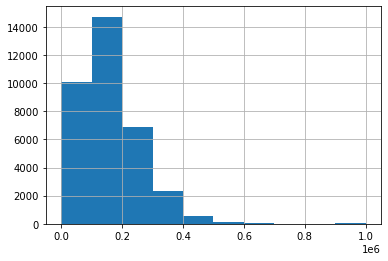

In [55]:
test.mileage.hist();

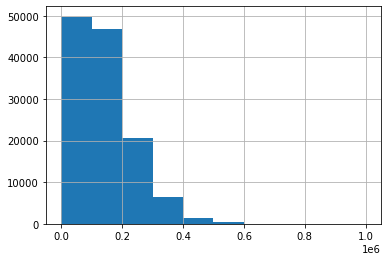

In [56]:
train.mileage.hist();

In [57]:
train['mil_per_year'] = train.mileage / (2021 - train.productionDate)
test['mil_per_year'] = test.mileage / (2021 - test.productionDate)

### modelDate

In [58]:
test.modelDate.unique()

array([2013, 2017, 2008, 2009, 2016, 2012, 2015, 2010, 2006, 2000, 2007,
       1994, 2004, 1999, 2005, 1976, 2001, 1969, 1996, 1998, 1989, 1934,
       2014, 2011, 2018, 1986, 1997, 1990, 2019, 2002, 1991, 1987, 1980,
       1982, 1938, 1988, 2003, 1983, 1978, 1979, 1984, 1992, 1995, 1993,
       1985, 1974, 1966, 1977, 1981, 1972, 1968, 1975, 1949, 1937, 1936,
       1973, 1959, 1958, 2020, 1965, 1971, 1904, 1963, 1955, 1951, 1960])

In [59]:
test.modelDate.describe()

count    34686.000000
mean      2007.074728
std          7.415894
min       1904.000000
25%       2004.000000
50%       2008.000000
75%       2012.000000
max       2020.000000
Name: modelDate, dtype: float64

In [60]:
train.modelDate.describe()

count    125587.000000
mean       2008.828119
std           7.486112
min        1904.000000
25%        2005.000000
50%        2010.000000
75%        2015.000000
max        2020.000000
Name: modelDate, dtype: float64

### model_name

In [61]:
set(test.model_name) - set(train.model_name)

{'ARTEON',
 'COROLLA_II',
 'GOLF_R32',
 'LANCER_RALLIART',
 'POLO_GTI',
 'PORTE',
 'PRESEA',
 'RSQ3',
 'WILL_CYPHA',
 'X4_M'}

In [62]:
print(test.model_name.nunique(), train.model_name.nunique())

544 1278


In [63]:
# to_delete.append('model_name')
# удаление признака не улучшило метрику

### name

In [64]:
test.name.head()

0        1.2 AMT (105 л.с.)
1         1.6 MT (110 л.с.)
2    DSG 1.8 AMT (152 л.с.)
3         1.6 AT (110 л.с.)
4         1.8 AT (152 л.с.)
Name: name, dtype: object

In [65]:
train.name.head()

0    2.8 MT (174 л.с.) 4WD
1         1.8 MT (90 л.с.)
2    2.3 MT (136 л.с.) 4WD
3         1.8 MT (90 л.с.)
4        2.0 MT (101 л.с.)
Name: name, dtype: object

In [66]:
# def name_prep(name):
#     idx = str(name).find('л.с.')
#     if idx == -1:
#         return 100
#     new = name[idx - 6 : idx]
#     new = ''.join(c for c in new if c.isdigit())
#     return np.int64(new)

# train.name = train.name.apply(name_prep)
# test.name = test.name.apply(name_prep)

In [67]:
to_delete.append('name')
# это комбинация других признаков, удаление признака улучшило метрику

### numberOfDoors

In [68]:
test.numberOfDoors.unique()

array([5, 4, 2, 3, 0])

In [69]:
train.numberOfDoors.unique()

array([4., 5., 3., 2., 0.])

### productionDate

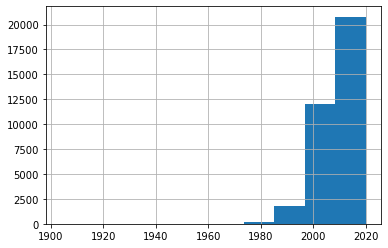

In [70]:
test.productionDate.hist();

In [71]:
test.productionDate.describe()

count    34686.000000
mean      2009.264602
std          7.047661
min       1904.000000
25%       2006.000000
50%       2011.000000
75%       2014.000000
max       2020.000000
Name: productionDate, dtype: float64

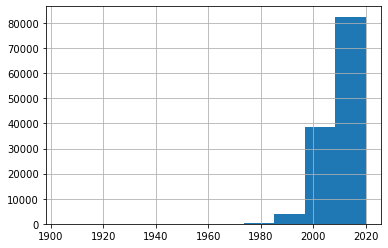

In [72]:
train.productionDate.hist();

In [73]:
train.productionDate.describe()

count    125587.000000
mean       2011.078559
std           7.123826
min        1904.000000
25%        2007.000000
50%        2012.000000
75%        2017.000000
max        2020.000000
Name: productionDate, dtype: float64

In [74]:
train['age_of_model'] = train.productionDate - train.modelDate
test['age_of_model'] = test.productionDate - test.modelDate

train.productionDate = 2021 - train.productionDate
test.productionDate = 2021 - test.productionDate
train.modelDate = 2021 - train.modelDate
test.modelDate = 2021 - test.modelDate
# Хотя эти признаки коррелируют удаление одноги из них ухудшает метрику

### vehicleConfiguration

In [75]:
test.vehicleConfiguration

0                   LIFTBACK ROBOT 1.2
1              LIFTBACK MECHANICAL 1.6
2                   LIFTBACK ROBOT 1.8
3               LIFTBACK AUTOMATIC 1.6
4               LIFTBACK AUTOMATIC 1.8
                     ...              
34681              SEDAN AUTOMATIC 1.6
34682              SEDAN AUTOMATIC 2.0
34683              SEDAN AUTOMATIC 2.5
34684    ALLROAD_5_DOORS AUTOMATIC 2.0
34685    ALLROAD_5_DOORS AUTOMATIC 3.0
Name: vehicleConfiguration, Length: 34686, dtype: object

In [76]:
train.vehicleConfiguration

0                 SEDAN MECHANICAL 2.8
1                 SEDAN MECHANICAL 1.8
2         WAGON_5_DOORS MECHANICAL 2.3
3                 SEDAN MECHANICAL 1.8
4                 SEDAN MECHANICAL 2.0
                      ...             
125582              LIFTBACK ROBOT 3.0
125583                 SEDAN ROBOT 2.0
125584              LIFTBACK ROBOT 3.0
125585         WAGON_5_DOORS ROBOT 2.0
125586     WAGON_5_DOORS AUTOMATIC 2.4
Name: vehicleConfiguration, Length: 125587, dtype: object

In [77]:
to_delete.append('vehicleConfiguration')
# содержимое признака уже представлено в других признаках, удаление помогло

### vehicleTransmission

In [78]:
test.vehicleTransmission.unique()

array(['роботизированная', 'механическая', 'автоматическая', 'вариатор'],
      dtype=object)

In [79]:
train.vehicleTransmission.unique()

array(['MECHANICAL', 'AUTOMATIC', 'ROBOT', 'VARIATOR', 'автоматическая',
       'роботизированная', 'вариатор', 'механическая'], dtype=object)

In [80]:
transmission_dict = {
    'роботизированная' : 'ROBOT', 'механическая' : 'MECHANICAL', 
    'автоматическая' : 'AUTOMATIC', 'вариатор' : 'VARIATOR'
}
tsm_list = ['ROBOT', 'AUTOMATIC', 'MECHANICAL', 'VARIATOR']

train.vehicleTransmission = train.vehicleTransmission.apply(lambda x: x if x in tsm_list else transmission_dict[x])
test.vehicleTransmission = test.vehicleTransmission.map(transmission_dict)

In [81]:
train.vehicleTransmission.value_counts()

AUTOMATIC     68844
MECHANICAL    32149
ROBOT         12737
VARIATOR      11857
Name: vehicleTransmission, dtype: int64

In [82]:
test.vehicleTransmission.value_counts()

AUTOMATIC     19596
MECHANICAL     7209
VARIATOR       3999
ROBOT          3882
Name: vehicleTransmission, dtype: int64

In [83]:
train.groupby(['vehicleTransmission'])['price'].mean().to_dict()

{'AUTOMATIC': 1885654.5818134104,
 'MECHANICAL': 453410.010454049,
 'ROBOT': 1625561.9735516373,
 'VARIATOR': 1337504.7705042656}

### Владельцы

In [84]:
test['Владельцы'].unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца'], dtype=object)

In [85]:
test['Владельцы'] = test['Владельцы'].apply(lambda x: x[0])
test['Владельцы'].unique()

array(['3', '1', '2'], dtype=object)

In [86]:
train['Владельцы'].unique()

array([3.0, 1.0, 2.0, nan, '2\xa0владельца', '1\xa0владелец',
       'Неизвестно', '3 или более'], dtype=object)

In [87]:
train['Владельцы'].fillna('0', inplace=True)
train['Владельцы'] = train['Владельцы'].apply(lambda x: '0' if x == 'Неизвестно' else x)
train['Владельцы'] = train['Владельцы'].astype(str)

train['Владельцы'] = train['Владельцы'].apply(lambda x: x[0])
train['Владельцы'].unique()

array(['3', '1', '2', '0'], dtype=object)

In [88]:
train[train['Владельцы'] == '0']['productionDate'].value_counts()

1     18560
2      1540
3       103
13        1
9         1
21        1
20        1
4         1
Name: productionDate, dtype: int64

In [89]:
test[test['Владельцы'] == '1']['productionDate'].value_counts()

3      1182
4      1078
2       945
5       885
7       835
8       803
6       798
9       711
10      521
13      328
11      304
1       249
14      189
12      136
15       99
16       61
17       47
18       33
19       32
23       24
20       22
22       21
24       21
26       18
21       17
29       11
27       10
25        9
31        9
30        8
32        6
28        6
37        6
35        4
33        4
34        4
62        2
38        2
68        2
45        2
39        2
56        1
54        1
72        1
60        1
36        1
52        1
41        1
49        1
117       1
85        1
69        1
43        1
47        1
Name: productionDate, dtype: int64

In [90]:
# train['Владельцы'] = train['Владельцы'].apply(lambda x: '1' if x == '0' else x)
# train['Владельцы'].unique()

# заполнение пропущенных значении с 1-ой ухудшило результат 

### ПТС

In [91]:
test['ПТС'].unique()

array(['Оригинал', 'Дубликат', nan], dtype=object)

In [92]:
train['ПТС'].unique()

array(['ORIGINAL', 'DUPLICATE', nan, 'Оригинал', 'Дубликат'], dtype=object)

In [93]:
pts_dict = {
    'Оригинал' : 'ORIGINAL', 'Дубликат' : 'DUPLICATE'
}

pts_list = ['ORIGINAL', 'DUPLICATE']

test['ПТС'].fillna(test['ПТС'].mode()[0], inplace=True)
test['ПТС'] = test['ПТС'].map(pts_dict)
train['ПТС'].fillna(test['ПТС'].mode()[0], inplace=True)
train['ПТС'] = train['ПТС'].apply(lambda x: x if x in pts_list else pts_dict[x])

In [94]:
train['ПТС'].value_counts()

ORIGINAL     111112
DUPLICATE     14475
Name: ПТС, dtype: int64

In [95]:
test['ПТС'].value_counts()

ORIGINAL     30099
DUPLICATE     4587
Name: ПТС, dtype: int64

### Привод

In [96]:
test['Привод'].value_counts()

передний    15565
полный      15020
задний       4101
Name: Привод, dtype: int64

In [97]:
train['Привод'].value_counts()

передний    62487
полный      53275
задний       9825
Name: Привод, dtype: int64

In [98]:
train['tms_pri'] = train.vehicleTransmission + '-' + train['Привод']
test['tms_pri'] = test.vehicleTransmission + '-' + test['Привод']

# новый признак из комбинации двух признаков улучшило результат

### Руль

In [99]:
test['Руль'].unique()

array(['Левый', 'Правый'], dtype=object)

In [100]:
train['Руль'].unique()

array(['LEFT', 'RIGHT', 'Левый', 'Правый'], dtype=object)

In [101]:
train['Руль'] = train['Руль'].replace('LEFT', 'Левый')
train['Руль'] = train['Руль'].replace('RIGHT', 'Правый')

train['Руль'].value_counts()

Левый     122628
Правый      2959
Name: Руль, dtype: int64

In [102]:
test['Руль'].value_counts()

Левый     33287
Правый     1399
Name: Руль, dtype: int64

### price

In [103]:
train.price.isna().sum()

410

In [104]:
train = train[train['price'].notna()]

In [105]:
train.price.describe()

count    1.251770e+05
mean     1.440764e+06
std      2.085457e+06
min      1.600000e+04
25%      3.950000e+05
50%      7.500000e+05
75%      1.700000e+06
max      9.900000e+07
Name: price, dtype: float64

In [106]:
train.price = np.log(train.price)

In [107]:
train.drop(columns=to_delete, inplace=True)
test.drop(columns=to_delete, inplace=True)

In [108]:
train.isna().sum()

bodyType               0
brand                  0
color                  0
enginePower            0
fuelType               0
mileage                0
modelDate              0
model_name             0
numberOfDoors          0
productionDate         0
vehicleTransmission    0
Владельцы              0
ПТС                    0
Привод                 0
Руль                   0
price                  0
bodyType_mean          0
brand_mean             0
mil_per_year           0
age_of_model           0
tms_pri                0
dtype: int64

In [109]:
test.isna().sum()

bodyType               0
brand                  0
color                  0
enginePower            0
fuelType               0
mileage                0
modelDate              0
model_name             0
numberOfDoors          0
productionDate         0
vehicleTransmission    0
Владельцы              0
ПТС                    0
Привод                 0
Руль                   0
bodyType_mean          0
brand_mean             0
mil_per_year           0
age_of_model           0
tms_pri                0
dtype: int64

In [110]:
train.shape

(125177, 21)

In [111]:
train.drop_duplicates(inplace=True)

In [112]:
train.shape

(114017, 21)

In [113]:
y = train['price'].values
train.drop(['price'], axis=1,inplace=True)

train['is_train'] = 1
test['is_train'] = 0

data = pd.concat([train, test], ignore_index=True)

In [114]:
data.columns

Index(['bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage',
       'modelDate', 'model_name', 'numberOfDoors', 'productionDate',
       'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль',
       'bodyType_mean', 'brand_mean', 'mil_per_year', 'age_of_model',
       'tms_pri', 'is_train'],
      dtype='object')

In [115]:
numeric_cols = ['modelDate', 'numberOfDoors', 'productionDate', 'Владельцы', 'age_of_model']

for feature in numeric_cols:  
    data[feature] = data[feature].astype('int64')

num_features = ['enginePower', 'mileage', 'modelDate', 'bodyType_mean',
                'brand_mean', 'mil_per_year']   # 'productionDate', 'age_of_model'
cat_features = ['bodyType', 'brand', 'color', 'fuelType', 'numberOfDoors', 'model_name',
                'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'tms_pri']


for colum in cat_features:
    data[colum] = data[colum].astype('category').cat.codes

In [116]:
data

,bodyType,brand,color,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,...,Владельцы,ПТС,Привод,Руль,bodyType_mean,brand_mean,mil_per_year,age_of_model,tms_pri,is_train
0,15,0,15,174.0,0,350000,31,3,3,30,...,3,1,2,0,1.116970e+06,1.596766e+06,11666.666667,1,5,1
1,15,0,7,90.0,0,173424,39,3,3,35,...,3,1,1,0,1.116970e+06,1.596766e+06,4954.971429,4,4,1
2,20,0,13,136.0,0,230000,33,3,4,32,...,3,1,2,0,6.257633e+05,1.596766e+06,7187.500000,1,5,1
3,15,0,11,90.0,0,240000,33,3,3,32,...,3,1,1,0,1.116970e+06,1.596766e+06,7500.000000,1,4,1
4,15,0,15,101.0,0,300000,31,3,3,30,...,3,0,1,0,1.116970e+06,1.596766e+06,10000.000000,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148698,15,1,6,136.0,0,115000,10,58,3,7,...,3,1,0,0,1.116970e+06,2.459770e+06,16428.571429,3,0,0
148699,15,1,15,190.0,3,98000,5,75,3,3,...,1,1,2,0,1.116970e+06,2.459770e+06,32666.666667,2,2,0
148700,15,1,12,170.0,0,360000,26,75,3,24,...,3,0,0,0,1.116970e+06,2.459770e+06,15000.000000,2,0,0
148701,1,1,6,184.0,3,90500,9,1232,4,8,...,2,1,2,0,2.116855e+06,2.459770e+06,11312.500000,1,2,0


In [117]:
poly = PolynomialFeatures(2, interaction_only=True)
data_num = pd.DataFrame(poly.fit_transform(data[num_features].values))

data_num.dropna(axis=1, inplace=True)
data_num.drop(columns=np.where(data_num.apply(pd.Series.nunique) < 10000)[0].tolist(), inplace=True)
# экспериментальным путем было выявлено что полинамиальные признаки  с уникальными значениями больше 10000 улучшает метрику

data = pd.concat([data,data_num], axis=1)

In [118]:
data.head()

,bodyType,brand,color,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,...,6,7,11,12,13,14,15,18,20,21
0,15,0,15,174.0,0,350000,31,3,3,30,...,11666.666667,60900000.0,2.030000e+06,10850000.0,3.909394e+11,5.588682e+11,4.083333e+09,361666.666667,1.303131e+10,1.862894e+10
1,15,0,7,90.0,0,173424,39,3,3,35,...,4954.971429,15608160.0,4.459474e+05,6763536.0,1.937094e+11,2.769176e+11,8.593110e+08,193243.885714,5.534553e+09,7.911931e+09
2,20,0,13,136.0,0,230000,33,3,4,32,...,7187.500000,31280000.0,9.775000e+05,7590000.0,1.439256e+11,3.672563e+11,1.653125e+09,237187.500000,4.497674e+09,1.147676e+10
3,15,0,11,90.0,0,240000,33,3,3,32,...,7500.000000,21600000.0,6.750000e+05,7920000.0,2.680727e+11,3.832239e+11,1.800000e+09,247500.000000,8.377273e+09,1.197575e+10
4,15,0,15,101.0,0,300000,31,3,3,30,...,10000.000000,30300000.0,1.010000e+06,9300000.0,3.350909e+11,4.790299e+11,3.000000e+09,310000.000000,1.116970e+10,1.596766e+10


In [119]:
data.nunique()

bodyType                  26
brand                     13
color                     16
enginePower              400
fuelType                   5
mileage                28378
modelDate                 79
model_name              1288
numberOfDoors              5
productionDate            80
vehicleTransmission        4
Владельцы                  4
ПТС                        2
Привод                     3
Руль                       2
bodyType_mean             26
brand_mean                13
mil_per_year           35227
age_of_model              32
tms_pri                   12
is_train                   2
2                      28378
6                      35227
7                      48914
11                     67741
12                     37517
13                     36949
14                     39399
15                     40893
18                     45965
20                     49226
21                     54555
dtype: int64

In [120]:
columns = {'Владельцы' : 'num_owners', 'ПТС' : 'pts', 'Привод' : 'pri', 'Руль' : 'rull'}
data.rename(columns=columns, inplace=True)

cat_features = [columns[feat] if feat in columns else feat for feat in cat_features]
# cat_features.remove('model_name')

In [121]:
X = data.query('is_train == 1').drop(['is_train'], axis=1)
test = data.query('is_train == 0').drop(['is_train'], axis=1)

In [122]:
scaling_features = num_features + ['productionDate', 'age_of_model'] + data_num.columns.tolist()

for feature in scaling_features:
    scaler = StandardScaler()
    X[feature] = scaler.fit_transform(X[feature].values.reshape(-1, 1))
    test[feature] = scaler.transform(test[feature].values.reshape(-1, 1))

### Train validation split

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Models

### RandomForestRegressor

In [124]:
# rf_reg = RandomForestRegressor(
#     random_state=RANDOM_SEED, n_estimators=300, n_jobs=-1
# )

# rf_reg.fit(X_train, y_train)

# rf_pred = rf_reg.predict(X_test)
# print(f"Точность модели по метрике MAPE: {(mape(np.exp(y_test), np.exp(rf_pred)))*100:0.2f}%")

In [125]:
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]

# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# rf = RandomForestRegressor()

# rf_random = RandomizedSearchCV(
#     estimator = rf, 
#     param_distributions = random_grid, 
#     n_iter = 10, 
#     cv = 5, 
#     verbose=2, 
#     random_state=RANDOM_SEED,
#     n_jobs = -1
# )

# rf_random.fit(X_train, y_train)

# rf_pred = rf_reg.predict(X_test)
# print(f"Точность модели по метрике MAPE: {(mape(np.exp(y_test), np.exp(rf_pred)))*100:0.2f}%")

### Catboost Regressor

In [126]:
# model = CatBoostRegressor(
#     iterations = ITERATIONS,
#     learning_rate=0.1,
#     depth=10,
#     task_type='GPU',
#     random_seed = RANDOM_SEED,
#     eval_metric='MAPE'
# )

# # grid = {
# #     'learning_rate': np.arange(0.01, 0.1, 0.005),
# #     'depth': [4, 6, 10, 12],
# #     'l2_leaf_reg': [1, 3, 5, 7, 9]
# # }

# # randomized_search_result = model.randomized_search(grid,
# #                                                    X=X_train,
# #                                                    y=y_train,
# #                                                    plot=True)

# model.fit(X_train, y_train,
#          cat_features=cat_features,
#          eval_set=(X_test, y_test),
#          verbose_eval=100,
#          use_best_model=True,
#          plot=True
# )


# predict = model.predict(X_test)
# print(f"Точность модели по метрике MAPE: {(mape(np.exp(y_test), np.exp(predict)))*100:0.2f}%")

# feature_importances = pd.DataFrame()
# feature_importances['name'] = model.feature_names_
# feature_importances['importance'] = model.feature_importances_
# feature_importances.sort_values('importance', ascending=False, ignore_index=True)


# predict_submission = np.exp(model.predict(test))

# sample_submission['price'] = predict_submission
# sample_submission.to_csv(f'submission_catboost_v{VERSION}.csv', index=False)
# sample_submission.head(10)

#### Catboost на LB показал ~20% что заметно хуже чем другие модели

## XGBOOST

In [127]:
# xgb_model = xgb.XGBRegressor(
#     objective='reg:squarederror', tree_method='gpu_hist', sampling_method='gradient_based', seed=RANDOM_SEED
# )

# param_grid = {
#     'n_estimators': np.arange(500, 2000, 100),
#     'max_depth': [3, 5, 8, 10, 11, 13, 15, 18],
#     'learning_rate': np.arange(0.005, 0.1, 0.0005),
#     'subsample': np.arange(0.8, 1.0, 0.01),
#     'colsample_bylevel': np.arange(0.7, 1.0, 0.05),
#     'colsample_bytree': np.arange(0.7, 1.0, 0.05),
#     'colsample_bynode': np.arange(0.7, 1.0, 0.05)
# }

# kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# scoring = make_scorer(mape)

# grid_search = RandomizedSearchCV(xgb_model, param_grid, scoring=scoring, n_iter=2, cv=kfold)
# grid_result = grid_search.fit(X_train,y_train)
# grid_result.best_params_

In [128]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', tree_method='gpu_hist', sampling_method='gradient_based',
    learning_rate=0.05, max_depth=11, n_estimators=1100, alpha=1, seed=RANDOM_SEED,
    colsample_bytree=0.8, colsample_bynode=0.9, subsample=0.95
)

xgb_model.fit(X_train, y_train)

# learning_rate=0.05, max_depth=11, n_estimators=1000, alpha=1    --->      12.50

# learning_rate=0.05, max_depth=11, n_estimators=1100, alpha=1, colsample_bytree=0.8   --->     12.46

# learning_rate=0.05, max_depth=11, n_estimators=1100, alpha=1,
# colsample_bytree=0.8, colsample_bynode=0.9, subsample=0.95       --->      12.43  - 9.96512 LB

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=0.9, colsample_bytree=0.8, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=11,
             min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=1100, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=1, reg_lambda=1, sampling_method='gradient_based',
             scale_pos_weight=1, seed=42, subsample=0.95,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [129]:
xgb_pred = xgb_model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(np.exp(y_test), np.exp(xgb_pred)))*100:0.2f}%")

Точность модели по метрике MAPE: 12.43%


In [130]:
predict_submission = np.exp(xgb_model.predict(test))

sample_submission_final['price_xgb'] = predict_submission
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_xgb_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6.103541e+05
1,1100549428,9.263072e+05
2,1100658222,9.127136e+05
3,1100937408,7.357481e+05
4,1101037972,7.562801e+05
5,1100912634,7.618410e+05
6,1101228730,5.956781e+05
7,1100165896,3.734654e+05
8,1100768262,1.957840e+06
9,1101218501,8.064599e+05


#### XGBOOST Regressor score in LB is 9.96512

## LGBM

In [131]:
hyper_params = {
    'task': 'train',
    'objective': 'regression',
    'metric': ['mape'],
    'learning_rate': 0.02,
    'colsample_bytree': 0.75,
    'min_child_samples': 10,
    'max_depth': 25,
#     'max_bins': 61,
    'num_leaves': 512,  
    'n_estimators': 5000,
    'random_state': RANDOM_SEED,
#     'device': 'gpu',
#     'gpu_platform_id': 0,
#     'gpu_device_id': 0,
    'verbose': -1
}


lgbm = lgb.LGBMRegressor(**hyper_params)
lgbm.fit(X_train, y_train,
         eval_set=[(X_test, y_test)],
         eval_metric='mape',
         early_stopping_rounds=100
        )

[1]	valid_0's mape: 0.0594522
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.0583302
[3]	valid_0's mape: 0.0572329
[4]	valid_0's mape: 0.0561685
[5]	valid_0's mape: 0.0551311
[6]	valid_0's mape: 0.0541013
[7]	valid_0's mape: 0.0531016
[8]	valid_0's mape: 0.0521264
[9]	valid_0's mape: 0.0511667
[10]	valid_0's mape: 0.0502186
[11]	valid_0's mape: 0.0493062
[12]	valid_0's mape: 0.0483897
[13]	valid_0's mape: 0.0474986
[14]	valid_0's mape: 0.0466249
[15]	valid_0's mape: 0.0457677
[16]	valid_0's mape: 0.0449249
[17]	valid_0's mape: 0.0441201
[18]	valid_0's mape: 0.0433151
[19]	valid_0's mape: 0.0425264
[20]	valid_0's mape: 0.0417757
[21]	valid_0's mape: 0.0410239
[22]	valid_0's mape: 0.0403031
[23]	valid_0's mape: 0.0395884
[24]	valid_0's mape: 0.0388868
[25]	valid_0's mape: 0.0382098
[26]	valid_0's mape: 0.0375294
[27]	valid_0's mape: 0.03686
[28]	valid_0's mape: 0.0362075
[29]	valid_0's mape: 0.0355696
[30]	valid_0's mape: 0.0349416
[31]	valid_0's mape

LGBMRegressor(colsample_bytree=0.75, learning_rate=0.02, max_depth=25,
              metric=['mape'], min_child_samples=10, n_estimators=5000,
              num_leaves=512, objective='regression', random_state=42,
              task='train', verbose=-1)

In [132]:
lgbm_pred = lgbm.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(np.exp(y_test), np.exp(lgbm_pred)))*100:0.2f}%")

Точность модели по метрике MAPE: 12.42%


In [133]:
predict_submission = np.exp(lgbm.predict(test))

sample_submission_final['price_lgbm'] = predict_submission
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_lgbm_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,5.883854e+05
1,1100549428,9.320627e+05
2,1100658222,8.937097e+05
3,1100937408,7.669530e+05
4,1101037972,7.372900e+05
5,1100912634,7.660845e+05
6,1101228730,6.171297e+05
7,1100165896,3.729405e+05
8,1100768262,1.882795e+06
9,1101218501,8.271861e+05


#### LGBM Regressor score in LB is 9.68420

### Stacking

In [134]:
# LB score --->  10.15683

# estimators = [
#     ('xgb', xgb_model),
#     ('lgbm', lgbm),
#     ('rf_reg', RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=300))
# ]

# reg = StackingRegressor(
#     estimators=estimators,
#     final_estimator=xgb.XGBRegressor(objective='reg:squarederror', 
#                                      tree_method='gpu_hist', 
#                                      sampling_method='gradient_based', 
#                                      seed=RANDOM_SEED),
#     passthrough=True
# )

# reg.fit(X_train, y_train)

In [135]:
# LB score --->  9.63778

# estimators = [
#     ('xgb', xgb_model),
#     ('lgbm', lgbm)
# ]

# reg = StackingRegressor(
#     estimators=estimators,
#     final_estimator=lgb.LGBMRegressor(task='train',
#                                       objective='regression',
#                                       metric=['mape'],
#                                       random_state=RANDOM_SEED,
#                                      ),
#     passthrough=True
# )

# reg.fit(X_train, y_train)

In [136]:
# LB score  --->  9.26548

# estimators = [
#     ('xgb', xgb_model),
#     ('lgbm', lgbm),
#     ('adab', AdaBoostRegressor(random_state=RANDOM_SEED))
# ]

# reg = StackingRegressor(
#     estimators=estimators,
#     final_estimator=RidgeCV(),
#     cv=5,
#     passthrough=False
# )

# reg.fit(X_train, y_train)

In [137]:
# best

estimators = [
    ('xgb', xgb_model),
    ('lgbm', lgbm)
]

# scoring = make_scorer(mape)

reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(),
    cv=5,
    passthrough=False
)

reg.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('xgb',
                               XGBRegressor(alpha=1, base_score=0.5,
                                            booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=0.9,
                                            colsample_bytree=0.8, gamma=0,
                                            gpu_id=0, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.05,
                                            max_delta_step=0, max_depth=11,
                                            min_child_weight=1, missing=nan,
                                            monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0...
                                            scale_pos_weight=1, seed=42,
                                            subsample=0.95,
       

In [138]:
stack_pred = reg.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(np.exp(y_test), np.exp(stack_pred)))*100:0.2f}%")

Точность модели по метрике MAPE: 12.34%


In [139]:
predict_submission = np.exp(reg.predict(test))

sample_submission_final['price_stack'] = predict_submission
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_stack_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,5.958119e+05
1,1100549428,9.185422e+05
2,1100658222,9.019044e+05
3,1100937408,7.456662e+05
4,1101037972,7.541345e+05
5,1100912634,7.695173e+05
6,1101228730,5.997698e+05
7,1100165896,3.625199e+05
8,1100768262,1.980725e+06
9,1101218501,8.133250e+05


In [140]:
sample_submission_final['price'] = (0.8 * sample_submission_final['price_stack'] + 
                                    0.125 * sample_submission_final['price_lgbm'] + 
                                    0.075 * sample_submission_final['price_xgb'])

sample_submission_final.drop(columns=['price_stack', 'price_xgb', 'price_lgbm'], inplace=True)
sample_submission_final.to_csv(f'submission_stack_fianl_v{VERSION}.csv', index=False)